In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/fer2013.csv"
import pandas as pd
df = pd.read_csv(path)

In [ ]:
df.size

107661

In [3]:
# split data
train_df = df[df['Usage'] == 'Training'].copy()
validation_df = df[df['Usage'] == 'PublicTest'].copy() 
test_df = df[df['Usage'] == 'PrivateTest'].copy() 

print(train_df.shape)
print(validation_df.shape)
print(validation_df.shape)

(28709, 3)
(3589, 3)
(3589, 3)


In [4]:
def load_data(dataset):
    label_array = []
    image_array = []
    for index, row in dataset.iterrows():
        label_array.append(row['emotion'])
        
        # covert str to int
        img_arr = row['pixels'].split(' ')
        img_arr = np.array(img_arr).astype(int)
                    
        image_array.append(img_arr)
        
    return label_array, image_array

def view_data_image(dataset):
    plt.figure(figsize= (5,5))

    for i in range(1, 10, 1):
        plt.subplot(3, 3, i)
        
        img_arr = dataset[i]
        img_arr = img_arr.reshape((48, 48))
        
        plt.imshow(img_arr, cmap='gray')
    plt.show()

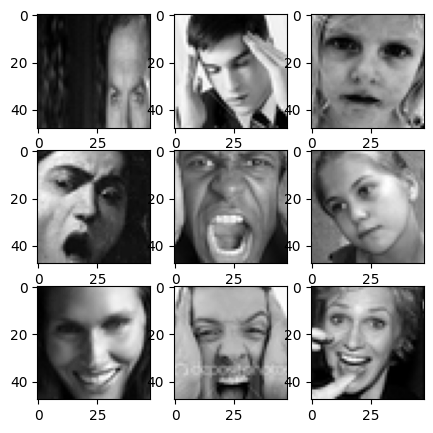

(3589, 2304)
(3589,)
(3589, 48, 48, 1)
(3589,)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
# split testing images and labels
test_label, test_image = load_data(test_df)

# visual image
view_data_image(test_image)

# convert list to numpy 
test_images = np.array(test_image).astype('float32')
print(test_images.shape)

test_labels = np.array(test_label).astype('int32')
print(test_labels.shape)

# convert numpy to tensor
test_images = np.array(test_image)
test_images = test_images.reshape((test_images.shape[0], 48, 48, 1))
print(test_images.shape)

test_labels = np.array(test_label)
print(test_labels.shape)

In [6]:
from tensorflow.keras.utils import to_categorical

# one-hot encoding
test_labels = to_categorical(test_labels)

In [7]:
# test_set generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.2,1.0),
                                    rescale=1./255,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,)

test_set = datagen_test.flow(test_images,
                                test_labels,
                                batch_size = batch_size,
                                shuffle = False)

# view
print(test_set)

In [9]:
from tensorflow.keras.models import load_model

# Load pre-trained FER model
model = load_model("/content/drive/MyDrive/model_1.h5") 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def check_model_performance(model, testing_data):
    test_pred = model.predict(testing_data)
    test_pred = np.argmax(test_pred, axis = -1)

    y_true_labels = testing_data.y
    y_true_labels = np.argmax(y_true_labels, axis = -1)
    
    print(classification_report(y_true_labels, test_pred))

    cm = confusion_matrix(y_true_labels, test_pred)

    plt.figure(figsize = (5, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f')

    plt.ylabel('Actual')

    plt.xlabel('Predicted')
    plt.title("PreTrained model Performace on FER dataset")

    plt.show()



113/113 [==============================] - 66s 582ms/step
              precision    recall  f1-score   support

           0       0.56      0.59      0.58       491
           1       0.53      0.47      0.50        55
           2       0.52      0.22      0.31       528
           3       0.84      0.90      0.87       879
           4       0.52      0.55      0.53       594
           5       0.69      0.79      0.74       416
           6       0.60      0.72      0.65       626

    accuracy                           0.65      3589
   macro avg       0.61      0.61      0.60      3589
weighted avg       0.64      0.65      0.63      3589



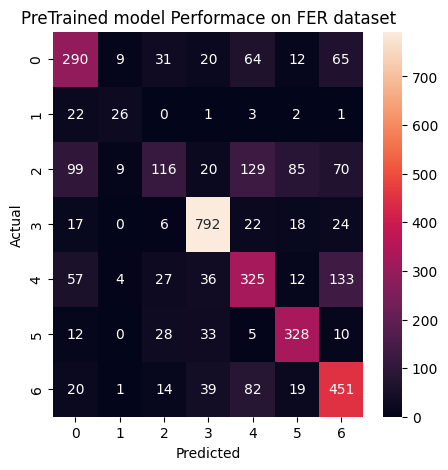

In [21]:
check_model_performance(model, test_set)

In [ ]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array


# Define emotion labels 
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load FER2013 dataset
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

# Extract pixel values and emotion labels from dataset
pixels = data['pixels'].tolist()
emotions = data['emotion'].tolist()
print(emotions)
# Define function to preprocess images
def preprocess_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize image to match FER model input shape (48x48 pixels)
    resized = cv2.resize(gray, (48, 48))
    # Expand dimensions to create a batch of size 1
    expanded = np.expand_dims(resized, axis=0)
    # Convert image to float32 and normalize pixel values
    preprocessed = expanded.astype('float32') / 255.0
    return preprocessed

# Define function to predict emotion from image
def predict_emotion(image):
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)
    emotion_idx = np.argmax(prediction)
    if emotion_idx < len(emotion_labels):
        emotion_label = emotion_labels[emotion_idx]
    else:
        emotion_label = "Unknown"
    return emotion_label

# Define function to classify emotion in video
def classify_emotion(video_path):
    cap = cv2.VideoCapture(video_path)
    emotions = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        emotion = predict_emotion(frame)
        emotions.append(emotion)
    cap.release()
    return emotions

# Test the emotion classification function on a video file
emotions = classify_emotion('/content/SaveInsta.App - 3082106782700544756.mp4')
print(emotions)


[0, 0, 2, 4, 6, 2, 4, 3, 3, 2, 0, 6, 6, 6, 3, 5, 3, 2, 6, 4, 4, 2, 0, 0, 3, 3, 5, 0, 3, 5, 3, 6, 3, 2, 3, 6, 6, 6, 0, 5, 0, 3, 4, 0, 6, 2, 3, 6, 2, 2, 2, 5, 5, 6, 4, 5, 0, 3, 4, 2, 6, 5, 3, 4, 3, 0, 4, 3, 0, 5, 4, 2, 4, 2, 0, 6, 0, 0, 5, 4, 3, 5, 3, 6, 2, 2, 4, 4, 5, 4, 0, 0, 6, 0, 6, 2, 2, 3, 4, 3, 3, 2, 6, 3, 4, 3, 2, 0, 2, 3, 2, 3, 6, 6, 3, 4, 4, 0, 3, 3, 0, 2, 0, 0, 3, 3, 0, 4, 5, 2, 4, 2, 5, 3, 0, 6, 6, 2, 2, 3, 2, 3, 3, 3, 3, 3, 4, 2, 2, 0, 0, 2, 6, 3, 4, 5, 3, 0, 2, 4, 5, 2, 3, 4, 6, 3, 4, 3, 6, 0, 4, 4, 4, 2, 6, 5, 5, 6, 5, 2, 3, 2, 3, 4, 0, 2, 0, 3, 0, 2, 2, 5, 3, 5, 5, 4, 3, 0, 6, 5, 2, 6, 0, 0, 4, 5, 6, 3, 5, 5, 3, 2, 2, 3, 3, 3, 3, 6, 3, 6, 3, 0, 6, 3, 2, 0, 6, 5, 6, 0, 5, 4, 3, 0, 3, 0, 4, 5, 4, 3, 3, 0, 0, 6, 2, 0, 6, 3, 0, 0, 6, 0, 5, 6, 3, 2, 5, 5, 2, 0, 2, 6, 6, 0, 2, 3, 4, 2, 6, 5, 2, 2, 6, 6, 6, 2, 5, 3, 0, 5, 0, 4, 3, 3, 3, 3, 6, 3, 2, 4, 6, 3, 2, 4, 0, 0, 3, 2, 0, 1, 2, 2, 5, 3, 5, 4, 4, 0, 2, 3, 4, 6, 4, 2, 2, 3, 5, 4, 4, 5, 6, 4, 5, 0, 3, 3, 3, 2, 5, 5, 5, 3, 5, 

In [ ]:
import collections
# using Counter to find frequency of elements
frequency = collections.Counter(emotions)
# printing the frequency
print(dict(frequency))

{}
